In [1]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import numpy as np

from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize, normalize, LabelEncoder
from sklearn.metrics import log_loss, classification_report
from sklearn.decomposition import PCA

from sklearn.cross_validation import cross_val_score, KFold, StratifiedKFold, train_test_split
from sklearn.feature_selection import RFECV
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

#from xgboost import XGBClassifier
#import xgboost as xgb

In [2]:
df = pd.read_csv('../input/train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26729 entries, 0 to 26728
Data columns (total 10 columns):
AnimalID          26729 non-null object
Name              19038 non-null object
DateTime          26729 non-null object
OutcomeType       26729 non-null object
OutcomeSubtype    13117 non-null object
AnimalType        26729 non-null object
SexuponOutcome    26728 non-null object
AgeuponOutcome    26711 non-null object
Breed             26729 non-null object
Color             26729 non-null object
dtypes: object(10)
memory usage: 2.2+ MB


In [3]:
df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


Obviously the age of the animals should be importante, so we need to clean it up a bit.
From the frist lines we can see that the age is in the format Numberperiod. 

Lets see what periods are there.

In [4]:
df['AgeuponOutcome'].str.split(expand=True)[1].unique()

array(['year', 'years', 'weeks', 'month', 'months', 'days', 'week', 'day',
       None], dtype=object)

So lets map each of these to a "multiplier", and calculate the age of the animals in days.

In [5]:
time_multiplier = dict(year = 365, years=365, weeks = 7, month = 30, months=30, days = 1, week = 7, day= 1)
foo = df['AgeuponOutcome'].str.split(expand=True)
age = foo[0].astype('float32')
period = foo[1]
del foo
period = period.map(time_multiplier)
df['age_in_days'] = age * period
df['age_in_years'] = df['age_in_days'] / 365
df['age_in_months'] = df['age_in_days'] / 30

In [6]:
print(df['SexuponOutcome'].str.split(expand=True)[0].unique())
print(df['SexuponOutcome'].str.split(expand=True)[1].unique())

['Neutered' 'Spayed' 'Intact' 'Unknown' nan]
['Male' 'Female' None]


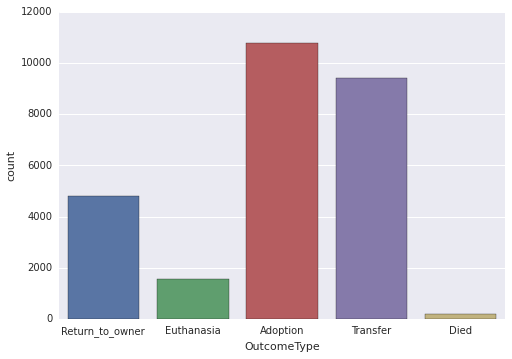

In [7]:
foo = df['SexuponOutcome'].str.split(expand=True)
df['condition'] = foo[0].map({'Neutered': 'operated', 'Spayed':'operated', 'Intact': 'intact', 'Unknown': 'unknown'})
df['sex'] = foo[1]
sns.countplot(x='OutcomeType', data=df)

So, it looks like most of the animals are being adopted or transfered. With some returning to their owner.
Only a small part of them are suffering euthanasia or dying (thanks god).

But how are these outcomes related to other characteristics of the animal? Are dogs and cats being are threated alike?

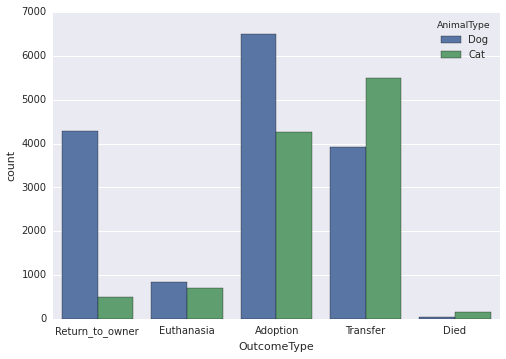

In [8]:
sns.countplot(x='OutcomeType', data=df, hue='AnimalType')

Dogs are prefered (as one would expect). The vast majority the animals returned to their owner are dogs. 
Dogs also haave a nice leading on adoption rate.
 
What about the sex?

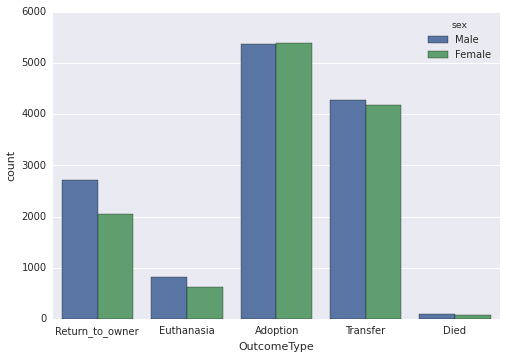

In [9]:
sns.countplot(x='OutcomeType', data=df, hue='sex')

So, in general the sex of the animal doesn't appear to have much influence on their final destinty.

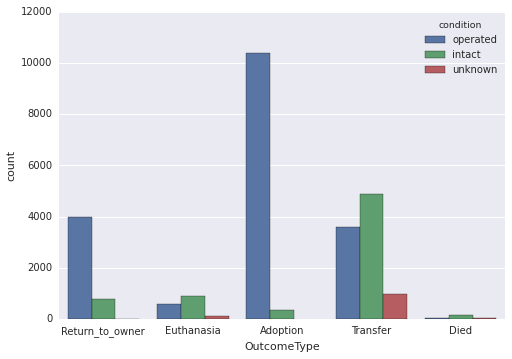

In [10]:
sns.countplot(x='OutcomeType', data=df, hue='condition')

Thats not the case when dealing on the codition of the animal. Most of the adopted or returned animals are operated.

Now lets see how the age influences this, for this we will use a boxplot.

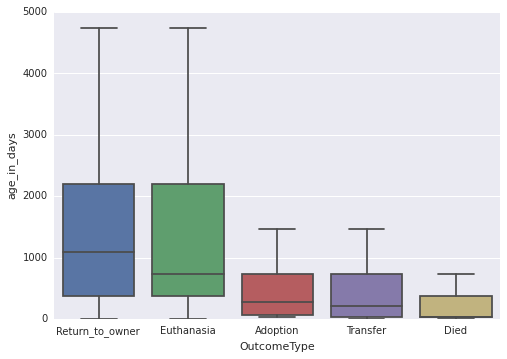

In [11]:
sns.boxplot(x='OutcomeType', y='age_in_days', data=df, showfliers=False) #showfliers=false disable the display of the outliers

Contrary to my initial expectations, young animals are the ones that die most, while old animmals return to their owner (the owner miss them?) or suffer from euthanasia (putting their out of their misery).

Adoptions are mainly about youg animals.

Lets see how the name of the animals influence their odds.

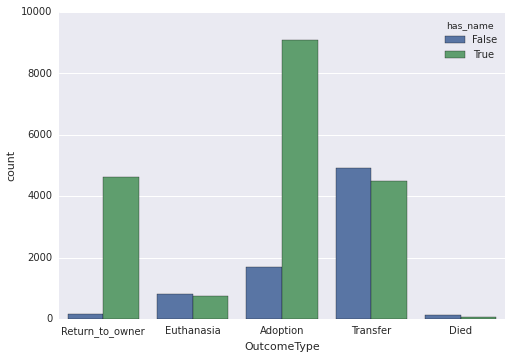

In [12]:
df['has_name'] = pd.notnull(df['Name'])
sns.countplot(x='OutcomeType', data=df, hue='has_name')

So, if the animal has a name people are more propensed to get them back or even adopt them (I get the case of return_to_owner, but... can't new owners give their pets a name?).

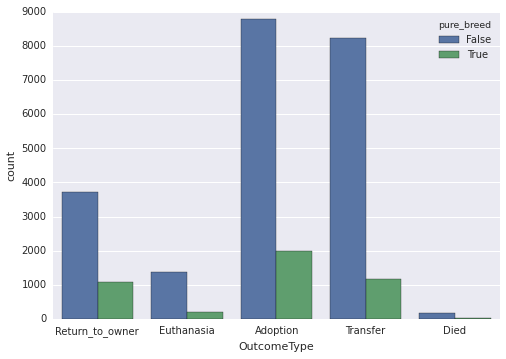

In [13]:
df['pure_breed'] = df.Breed.apply(lambda x : 'mix' not in x.lower())
sns.countplot(x='OutcomeType', data=df, hue='pure_breed')

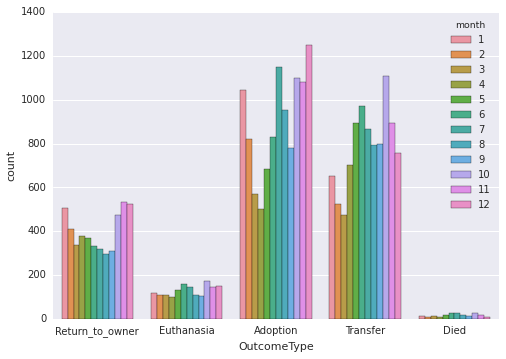

In [14]:
df.DateTime = pd.to_datetime(df.DateTime)
df['month'] = df.DateTime.dt.month.astype('category')
df['weekday'] = df.DateTime.dt.weekday.astype('category')
df['hour'] = df.DateTime.dt.hour.astype('category')
sns.countplot(x='OutcomeType', data=df, hue='month')

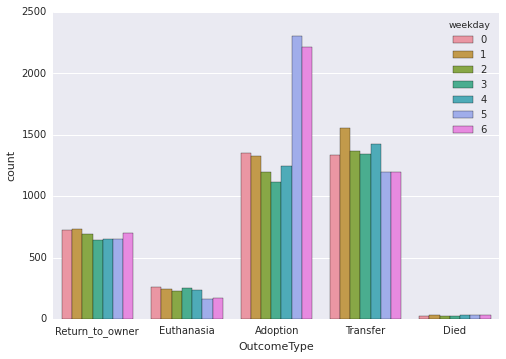

In [15]:
sns.countplot(x='OutcomeType', data=df, hue='weekday')

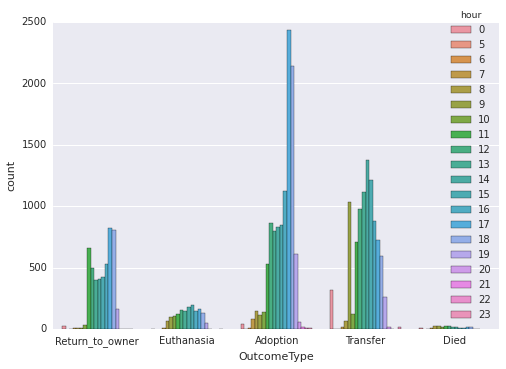

In [16]:
sns.countplot(x='OutcomeType', data=df, hue='hour')

In [17]:
color_split = df.Color.str.split('/', expand=True)
df['color_1'] = color_split[0]
print(df.color_1.unique())
df['color_2'] = color_split[1]
print(df.color_2.unique())

['Brown' 'Cream Tabby' 'Blue' 'Blue Cream' 'Tan' 'Black' 'Blue Tabby'
 'Brown Tabby' 'Red' 'White' 'Silver' 'Orange Tabby' 'Brown Brindle'
 'Chocolate' 'Calico' 'Torbie' 'Yellow' 'Tricolor' 'Tortie' 'Gray' 'Buff'
 'Seal Point' 'Yellow Brindle' 'Fawn' 'Flame Point' 'Black Tabby'
 'Red Tick' 'Blue Merle' 'Sable' 'Brown Merle' 'Brown Tiger' 'Liver'
 'Cream' 'Blue Point' 'Apricot' 'Red Merle' 'Lynx Point' 'Lilac Point'
 'Tortie Point' 'Gray Tabby' 'Blue Tiger' 'Gold' 'Blue Tick' 'Black Smoke'
 'Calico Point' 'Black Brindle' 'Silver Tabby' 'Orange' 'Chocolate Point'
 'Agouti' 'Blue Smoke' 'Liver Tick' 'Pink' 'Silver Lynx Point' 'Ruddy'
 'Black Tiger' 'Orange Tiger']
['White' None 'Tan' 'Red' 'Cream' 'Brown' 'Black' 'Calico' 'Brown Brindle'
 'Gray' 'Silver' 'Cream Tabby' 'Blue Tabby' 'Brown Tabby' 'Red Tick' 'Blue'
 'Orange Tabby' 'Tricolor' 'Orange' 'Blue Tiger' 'Lynx Point' 'Buff'
 'Chocolate Point' 'Liver' 'Gold' 'Black Brindle' 'Blue Merle' 'Blue Tick'
 'Chocolate' 'Blue Cream' 'Black Ta

In [18]:
print(df.Breed.value_counts()[:10])
print('---------')
print(df.Breed.str.replace(' Mix', '').value_counts()[:10])
print()
print()
print(len(df.Breed.value_counts()))
print(len(df.Breed.str.replace(' Mix', '').value_counts()))
df.Breed.value_counts()
df['breed_rarity']=  pd.cut(df.Breed.value_counts(), 5, include_lowest=True, labels=['super rare', 'rare', 'comon', 'very comon', 'very very common' ])

Domestic Shorthair Mix       8810
Pit Bull Mix                 1906
Chihuahua Shorthair Mix      1766
Labrador Retriever Mix       1363
Domestic Medium Hair Mix      839
German Shepherd Mix           575
Domestic Longhair Mix         520
Siamese Mix                   389
Australian Cattle Dog Mix     367
Dachshund Mix                 318
Name: Breed, dtype: int64
---------
Domestic Shorthair       8953
Pit Bull                 1972
Chihuahua Shorthair      1851
Labrador Retriever       1432
Domestic Medium Hair      881
German Shepherd           652
Domestic Longhair         543
Siamese                   413
Australian Cattle Dog     392
Dachshund                 364
Name: Breed, dtype: int64


1380
1244


In [19]:
y = df['OutcomeType']
x = df[['age_in_days', 'age_in_years', 'age_in_months', 'condition', 'sex','AnimalType', 'has_name', 'color_1', 'color_2', 'pure_breed', 'breed_rarity', 'hour', 'weekday', 'month']]
x = pd.get_dummies(x)
x.info(null_counts=True, memory_usage='deep', verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26729 entries, 0 to 26728
Data columns (total 157 columns):
age_in_days                      26711 non-null float64
age_in_years                     26711 non-null float64
age_in_months                    26711 non-null float64
has_name                         26729 non-null bool
pure_breed                       26729 non-null bool
condition_intact                 26729 non-null float64
condition_operated               26729 non-null float64
condition_unknown                26729 non-null float64
sex_Female                       26729 non-null float64
sex_Male                         26729 non-null float64
AnimalType_Cat                   26729 non-null float64
AnimalType_Dog                   26729 non-null float64
color_1_Agouti                   26729 non-null float64
color_1_Apricot                  26729 non-null float64
color_1_Black                    26729 non-null float64
color_1_Black Brindle            26729 non-null float64


Age in days has some null values. Lets fix it.

In [20]:
df2 = df[['OutcomeType', 'age_in_days','age_in_years', 'age_in_months', 'condition', 'sex','AnimalType', 'has_name', 'color_1', 'color_2', 'pure_breed', 'breed_rarity', 'hour', 'weekday', 'month']]
df2 = pd.get_dummies(df2.reindex(), columns=['condition', 'sex','AnimalType', 'has_name', 'color_1', 'color_2', 'pure_breed', 'breed_rarity', 'hour', 'weekday', 'month'])
df2.dropna(axis=0, inplace=True)
y = df2['OutcomeType']
x = df2.drop('OutcomeType', axis=1)
print(x.shape)
print(y.shape)

(26711, 159)
(26711,)


In [21]:
rf = RandomForestClassifier()
rf.fit(x, y)

y_pred = rf.predict_proba(x)
print(log_loss(y, y_pred))

0.191086421917


In [22]:
print('Top features')
for score, feat in sorted(zip(rf.feature_importances_, x.columns), reverse=True)[:10]:
    print('{:.3f} {}'.format(score,feat))
print()    
print('Botton features')
for score, feat in sorted(zip(rf.feature_importances_, x.columns), reverse=True)[-20:]:
    print('{:.5f} {}'.format(score,feat))

Top features
0.082 condition_operated
0.071 age_in_years
0.069 age_in_days
0.062 age_in_months
0.044 has_name_False
0.033 condition_intact
0.023 color_2_White
0.019 color_1_Black
0.019 AnimalType_Dog
0.015 hour_17

Botton features
0.00004 color_1_Liver Tick
0.00003 color_2_Apricot
0.00002 color_2_Black Smoke
0.00001 color_2_Brown Tiger
0.00001 color_2_Seal Point
0.00001 color_2_Blue Tiger
0.00001 hour_5
0.00000 color_1_Ruddy
0.00000 color_1_Silver Lynx Point
0.00000 color_2_Chocolate Point
0.00000 color_2_Lynx Point
0.00000 color_2_Black Tabby
0.00000 color_2_Flame Point
0.00000 color_2_Silver Tabby
0.00000 color_1_Pink
0.00000 breed_rarity_very very common
0.00000 breed_rarity_very comon
0.00000 breed_rarity_super rare
0.00000 breed_rarity_rare
0.00000 breed_rarity_comon


So age in days is really important... What if we bin it?
 
Also breed_rarity didn't help a bit. So lets remove it.

In [23]:
df['age_bined'] =  pd.cut(df.age_in_days, 10, include_lowest=True)

df2 = df[['age_bined', 'OutcomeType', 'condition', 'sex','AnimalType', 'has_name', 'color_1', 'color_2', 'pure_breed', 'hour', 'weekday', 'month']]
df2 = pd.get_dummies(df2.reindex(), columns=['age_bined', 'condition', 'sex','AnimalType', 'has_name', 'color_1', 'color_2', 'pure_breed', 'hour', 'weekday', 'month'])
df2.dropna(axis=0, inplace=True)
y = df2['OutcomeType']
x = df2.drop('OutcomeType', axis=1)

print(x.shape)
print(y.shape)

rf = RandomForestClassifier(n_estimators=30, max_depth=None)
rf.fit(x, y)
y_pred = rf.predict_proba(x)
print(log_loss(y, y_pred))

(26729, 161)
(26729,)
0.201897527649


In [24]:
print('Top features')
for score, feat in sorted(zip(rf.feature_importances_, x.columns), reverse=True)[:10]:
    print('{:.3f} {}'.format(score,feat))
print()    
print('Botton features')
for score, feat in sorted(zip(rf.feature_importances_, x.columns), reverse=True)[-10:]:
    print('{:.5f} {}'.format(score,feat))

Top features
0.072 condition_operated
0.048 condition_intact
0.035 has_name_False
0.031 color_2_White
0.030 age_bined_[-7.3, 730]
0.025 has_name_True
0.023 color_1_Black
0.018 hour_17
0.018 sex_Female
0.017 sex_Male

Botton features
0.00002 color_2_Black Tabby
0.00001 color_2_Blue Tiger
0.00001 hour_5
0.00001 color_1_Silver Lynx Point
0.00001 color_2_Brown Tiger
0.00000 color_1_Ruddy
0.00000 color_2_Flame Point
0.00000 color_2_Silver Tabby
0.00000 color_2_Chocolate Point
0.00000 color_1_Pink


So... binning the age didn't help a bit... Lets keep the age_in_days.
 
We can try using the breed information to augment the dataset, but its too large (lots of different values).
We can use it, but first we have to reduce the number of feature (columns) using PCA.

In [25]:
pca = PCA(20)
breed = pca.fit_transform(pd.get_dummies(df['Breed']))
print(breed.shape)
print(np.sum(pca.explained_variance_ratio_))

breed = pd.DataFrame(breed, columns=['breed_' + str(i) for i in range(breed.shape[1]) ])

(26729, 20)
0.655448918617


In [26]:
#df2 = df[['age_in_days', 'age_in_years', 'age_in_months', 'OutcomeType', 'condition', 'sex','AnimalType', 'has_name', 'color_1', 'color_2', 'pure_breed', 'hour', 'weekday', 'month']]
df2 = df[['age_in_years', 'OutcomeType', 'condition', 'sex','AnimalType', 'has_name', 'color_1', 'color_2', 'pure_breed', 'hour', 'weekday', 'month']]
df2 = pd.get_dummies(df2.reindex(), columns=['condition', 'sex','AnimalType', 'has_name', 'color_1', 'color_2', 'pure_breed', 'hour', 'weekday', 'month'])
df2 = pd.concat((df2, breed), axis=1)

df2.dropna(axis=0, inplace=True)
y = df2['OutcomeType']
x = df2.drop('OutcomeType', axis=1)

rf = RandomForestClassifier(n_estimators=30, max_depth=None)
rf.fit(x, y)
y_pred = rf.predict_proba(x)
print(log_loss(y, y_pred))

0.189216808415


In [27]:
print('Top features')
for score, feat in sorted(zip(rf.feature_importances_, x.columns), reverse=True)[:10]:
    print('{:.3f} {}'.format(score,feat))
print()    
print('Botton features')
for score, feat in sorted(zip(rf.feature_importances_, x.columns), reverse=True)[-10:]:
    print('{:.5f} {}'.format(score,feat))

Top features
0.129 age_in_years
0.065 condition_operated
0.049 condition_intact
0.027 has_name_False
0.024 has_name_True
0.019 color_2_White
0.016 color_1_Black
0.016 hour_17
0.015 sex_Male
0.015 sex_Female

Botton features
0.00001 color_2_Blue Tiger
0.00001 color_2_Seal Point
0.00001 hour_5
0.00000 color_1_Pink
0.00000 color_1_Silver Lynx Point
0.00000 color_2_Brown Tiger
0.00000 color_2_Silver Tabby
0.00000 color_2_Chocolate Point
0.00000 color_2_Flame Point
0.00000 color_1_Ruddy


While not among the top 10 features, obviously the breed of the animal helped a bit
 
Lets see how our model behaves on unseen data. To do it we will do crossvalidation

In [28]:
cross_val_score(RandomForestClassifier(), x, y , cv =3, scoring='log_loss')

array([-2.52991994, -2.46653841, -2.39445516])

eek! This is bad! The predictions are really BAD. But on the training set all was good... This indicates a problem of overfitting: the model understands the training really well but can't generalize to unseen problems.
When dealing with trees one way to overcome this is to control the max_depth of the tree. Lets see how this influences the predictions.

/usr/lib64/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


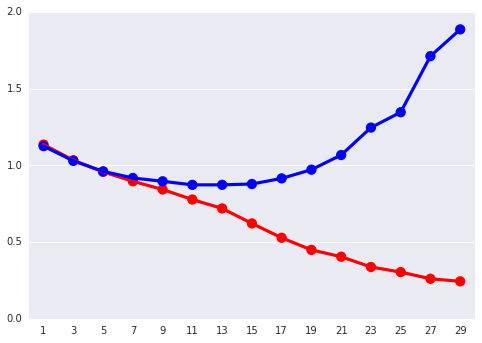

In [29]:
X_train, X_test, y_train,  y_test = train_test_split(x, y)
depth = list(range(1, 30, 2))
test_score = []
train_score = []
for d in depth:
    rfc = RandomForestClassifier(max_depth=d)
    rfc.fit(X_train, y_train)
    train_score.append(log_loss(y_train, rfc.predict_proba(X_train)))
    test_score.append(log_loss(y_test, rfc.predict_proba(X_test)))

ax = sns.pointplot(depth, train_score, color='red')
ax = sns.pointplot(depth, test_score, color='blue')

Thats the problem! The depth plays an important role here. Until depth is 9-10 all is good and is helps lower the training scores (a bit), but when we go above 13 the test results start increasing REALLY fast. So lets keep the depth at check with a value of 10.

As our data is also very unbalanced (very few animals die), we might take a look at the min_samples_leaf variable on RandomForests as well (this contrl how many itens must be at the leaf).

/usr/lib64/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


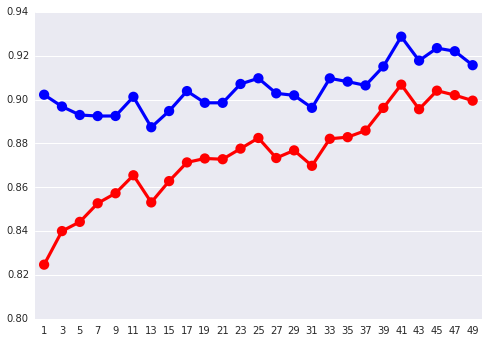

In [30]:
min_samples_leaf = list(range(1, 50, 2))
test_score = []
train_score = []
for m in min_samples_leaf:
    rfc = RandomForestClassifier(max_depth=10, min_samples_leaf= m, random_state=42)
    rfc.fit(X_train, y_train)
    train_score.append(log_loss(y_train, rfc.predict_proba(X_train)))
    test_score.append(log_loss(y_test, rfc.predict_proba(X_test)))

ax = sns.pointplot(min_samples_leaf, train_score, color='red')
ax = sns.pointplot(min_samples_leaf, test_score, color='blue')

/usr/lib64/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


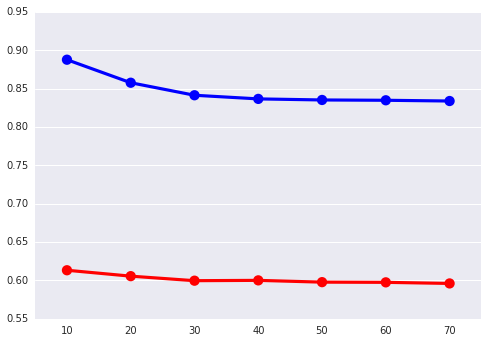

In [31]:
estimators = list(range(10, 80, 10))
test_score = []
train_score = []
for e in estimators:
    rfc = RandomForestClassifier(max_depth=15, min_samples_leaf=1, random_state=42, n_estimators=e)
    rfc.fit(X_train, y_train)
    train_score.append(log_loss(y_train, rfc.predict_proba(X_train)))
    test_score.append(log_loss(y_test, rfc.predict_proba(X_test)))

ax = sns.pointplot(estimators, train_score, color='red')
ax = sns.pointplot(estimators, test_score, color='blue')

So, above 40 trees we don't see much improvement? But maybe, now that we have more trees some of the other parameters can be changed. While we could go back and check max_depth and min_samples_leaf with the new values there is a better way: grid search with cross validation.

In [32]:
df.age_in_days = df.age_in_days.astype('category')
df2 = df[['age_in_days', 'OutcomeType', 'condition', 'sex','AnimalType', 'has_name', 'color_1', 'color_2', 'pure_breed', 'hour', 'weekday', 'month']]
df2 = pd.get_dummies(df2.reindex(), columns=['condition', 'sex', 'AnimalType', 'has_name', 'color_1', 'color_2', 'pure_breed', 'hour', 'weekday', 'month'])
df2 = pd.concat((df2, breed), axis=1)

df2.dropna(axis=0, inplace=True)
y = df2['OutcomeType']
x = df2.drop('OutcomeType', axis=1)

cross_val_score(RandomForestClassifier(max_depth=10, n_estimators=100), x, y , cv=3, scoring='log_loss')

array([-0.88085565, -0.87274527, -0.87020837])

In [33]:
rfc_params = {
    'n_estimators' : np.linspace(10, 100, 5, dtype='int'),
    'max_depth': np.linspace(2, 30, 6, dtype='int'),
    'min_samples_leaf': np.linspace(1, 15, 3, dtype='int'), 
}
grid = GridSearchCV(RandomForestClassifier(), rfc_params, verbose=3, scoring='log_loss', n_jobs=1)
grid.fit(x, y)
print(grid.best_score_)
print(grid.best_params_)

Fitting 3 folds for each of 90 candidates, totalling 270 fits
[CV] max_depth=2, min_samples_leaf=1, n_estimators=10 ................
[CV]  max_depth=2, min_samples_leaf=1, n_estimators=10, score=-1.058549 -   0.4s
[CV] max_depth=2, min_samples_leaf=1, n_estimators=10 ................


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.4s


[CV]  max_depth=2, min_samples_leaf=1, n_estimators=10, score=-1.067245 -   0.4s
[CV] max_depth=2, min_samples_leaf=1, n_estimators=10 ................
[CV]  max_depth=2, min_samples_leaf=1, n_estimators=10, score=-1.071087 -   0.4s
[CV] max_depth=2, min_samples_leaf=1, n_estimators=32 ................
[CV]  max_depth=2, min_samples_leaf=1, n_estimators=32, score=-1.081722 -   0.5s
[CV] max_depth=2, min_samples_leaf=1, n_estimators=32 ................
[CV]  max_depth=2, min_samples_leaf=1, n_estimators=32, score=-1.073525 -   0.5s
[CV] max_depth=2, min_samples_leaf=1, n_estimators=32 ................
[CV]  max_depth=2, min_samples_leaf=1, n_estimators=32, score=-1.053566 -   0.6s
[CV] max_depth=2, min_samples_leaf=1, n_estimators=55 ................
[CV]  max_depth=2, min_samples_leaf=1, n_estimators=55, score=-1.087033 -   0.7s
[CV] max_depth=2, min_samples_leaf=1, n_estimators=55 ................
[CV]  max_depth=2, min_samples_leaf=1, n_estimators=55, score=-1.088596 -   0.7s
[CV] ma

[Parallel(n_jobs=1)]: Done  32 jobs       | elapsed:   21.8s


[CV]  max_depth=2, min_samples_leaf=15, n_estimators=10, score=-1.106534 -   0.4s
[CV] max_depth=2, min_samples_leaf=15, n_estimators=32 ...............
[CV]  max_depth=2, min_samples_leaf=15, n_estimators=32, score=-1.092158 -   0.5s
[CV] max_depth=2, min_samples_leaf=15, n_estimators=32 ...............
[CV]  max_depth=2, min_samples_leaf=15, n_estimators=32, score=-1.074515 -   0.5s
[CV] max_depth=2, min_samples_leaf=15, n_estimators=32 ...............
[CV]  max_depth=2, min_samples_leaf=15, n_estimators=32, score=-1.072487 -   0.5s
[CV] max_depth=2, min_samples_leaf=15, n_estimators=55 ...............
[CV]  max_depth=2, min_samples_leaf=15, n_estimators=55, score=-1.096545 -   0.7s
[CV] max_depth=2, min_samples_leaf=15, n_estimators=55 ...............
[CV]  max_depth=2, min_samples_leaf=15, n_estimators=55, score=-1.080642 -   0.7s
[CV] max_depth=2, min_samples_leaf=15, n_estimators=55 ...............
[CV]  max_depth=2, min_samples_leaf=15, n_estimators=55, score=-1.074717 -   0.7s


[Parallel(n_jobs=1)]: Done 128 jobs       | elapsed:  2.4min


[CV]  max_depth=13, min_samples_leaf=15, n_estimators=55, score=-0.865791 -   1.6s
[CV] max_depth=13, min_samples_leaf=15, n_estimators=77 ..............
[CV]  max_depth=13, min_samples_leaf=15, n_estimators=77, score=-0.874210 -   2.1s
[CV] max_depth=13, min_samples_leaf=15, n_estimators=77 ..............
[CV]  max_depth=13, min_samples_leaf=15, n_estimators=77, score=-0.870379 -   2.1s
[CV] max_depth=13, min_samples_leaf=15, n_estimators=77 ..............
[CV]  max_depth=13, min_samples_leaf=15, n_estimators=77, score=-0.865293 -   2.1s
[CV] max_depth=13, min_samples_leaf=15, n_estimators=100 .............
[CV]  max_depth=13, min_samples_leaf=15, n_estimators=100, score=-0.874541 -   2.6s
[CV] max_depth=13, min_samples_leaf=15, n_estimators=100 .............
[CV]  max_depth=13, min_samples_leaf=15, n_estimators=100, score=-0.869401 -   2.7s
[CV] max_depth=13, min_samples_leaf=15, n_estimators=100 .............
[CV]  max_depth=13, min_samples_leaf=15, n_estimators=100, score=-0.865135

[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  7.6min finished


-0.818168525006
{'max_depth': 18, 'min_samples_leaf': 1, 'n_estimators': 100}


In [34]:
#xgb_params = dict(objective='multi:softprob',                    
#                  max_depth=6, 
#                  learning_rate=0.2,
#                  num_class=5,
#                  subsample=0.75, 
#                  colsample_bytree=0.85,)
#data = xgb.DMatrix(x, y)
#xgb.cv(xgb_params, data, num_boost_round=125,  metrics='mlogloss', verbose_eval=True)


In [35]:
#rfe = RFECV(RandomForestClassifier(max_depth=16, n_estimators=40), step=5, scoring='log_loss', verbose=0)
#rfe.fit(x, y)
#print(np.sum(rfe.support_))
#rfe.grid_scores_

In [36]:
x_reduzido = x.ix[:, rfe.get_support()]
x_red_train, x_red_test, y_train, y_test = train_test_split(x_reduzido, y, random_state=42)
rfc = RandomForestClassifier(max_depth=15, n_estimators=60, class_weight='balanced_subsample')
rfc.fit(x_red_train, y_train)
y_pred = rfc.predict(x_red_test)
y_pred_proba = rfc.predict_proba(x_red_test)
print(classification_report(y_test, y_pred))
print()
print(log_loss(y_test, y_pred_proba))

cm = confusion_matrix(y_test, y_pred)
print(cm)

print(np.sum(cm, axis=0))


NameError: name 'rfe' is not defined

In [ ]:
#foo = pd.concat( (x, y), axis=1)
#foo.shape
#foo.to_csv('../input/saida1.csv', index=False)